# Telecom project: Identifying Ineffective Operators

<strong>Goal</strong>: to identify ineffective operators in the virtual telephony service CallMeMaybe based on:
- the number of missed calls,
- waiting time for incoming calls,
- number of outgoing calls (if it is relevant for a particular operator). 


 * [Data preprocessing](#chapter1)
 * [EDA](#chapter2)
 * [Hypotheses testing](#chapter3)
 * [Applying machine learning](#chapter4)
 * [Conclusions and recommendations](#chapter5)

## Data preprocessing <a class="anchor" id="chapter1"></a>

### General information about datasets


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans



In [2]:
!pip install seaborn --upgrade


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 285 kB 1.2 MB/s eta 0:00:01


In [3]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [4]:
main_dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients = pd.read_csv('/datasets/telecom_clients_us.csv')
display(main_dataset.head())
display(main_dataset.info())
display(main_dataset.describe())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


None

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
As one may notice, there are explicit NaN values in operator_id and internal categories. In addition, some columns (date, internal) should be converted to the appropriate data types. It should be mentioned that there are at least 25% zero values in call_duration category. I assume that these values indicate missed calls (will be checked later).
</div>

In [5]:
display(clients.head())
display(clients.info())

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


None

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
There are not explicit NaN values in the dataset. The column date_start should be converted to the appropriate datatype.
</div>

### Type correspondence

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
There are several categories, the types of which should be converted to more appropriate ones:
    
<strong>First dataset:</strong>
- date: from String to date
- internal:I would choose '1/0' option (1 -True, 0 - False) for machine learning models and other calculations
- direction: 1 - in, 0 - out
    

<strong>Second dataset:</strong>
- date_start: string to date
</div>

In [6]:
main_dataset['date']= pd.to_datetime(main_dataset['date'], format='%Y-%m-%d %H:%M:%S') 
main_dataset['internal'] = pd.to_numeric(main_dataset['internal']*1)
main_dataset['is_missed_call'] = main_dataset['is_missed_call']*1

main_dataset.direction[main_dataset.direction == 'in'] = 1
main_dataset.direction[main_dataset.direction == 'out'] = 0
main_dataset['direction'] = main_dataset['direction'].astype('int')
main_dataset.info()
display(main_dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null datetime64[ns, pytz.FixedOffset(180)]
direction              53902 non-null int64
internal               53785 non-null float64
operator_id            45730 non-null float64
is_missed_call         53902 non-null int64
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: datetime64[ns, pytz.FixedOffset(180)](1), float64(2), int64(6)
memory usage: 3.7 MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,1,0.0,NaN,1,2,0,4
1,166377,2019-08-05 00:00:00+03:00,0,1.0,880022.0,1,3,0,5
2,166377,2019-08-05 00:00:00+03:00,0,1.0,880020.0,1,1,0,1
3,166377,2019-08-05 00:00:00+03:00,0,1.0,880020.0,0,1,10,18
4,166377,2019-08-05 00:00:00+03:00,0,0.0,880022.0,1,3,0,25


In [7]:
clients['date_start']= pd.to_datetime(clients['date_start'], format='%Y-%m-%d %H:%M:%S') 
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


### Processing missing values

In [8]:
main_dataset.isna().sum()/(len(main_dataset))*100

user_id                 0.000000
date                    0.000000
direction               0.000000
internal                0.217061
operator_id            15.160847
is_missed_call          0.000000
calls_count             0.000000
call_duration           0.000000
total_call_duration     0.000000
dtype: float64

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
    As it was mentioned there are missing values in <strong>internal</strong> and <strong>operator_id</strong> columns. While the number of NaN values in <strong>internal</strong> is not statistically significant and can be dropped, the NaNs in <strong>operator_id</strong> constitute 15% and cannot be ignored. Lets look at the rows with missing values in <strong>operator_id</strong>
</div>


In [9]:
nan_operator_id = main_dataset[main_dataset['operator_id'].isna()]
display(nan_operator_id.head())

categories_01 = ['call_duration', 'is_missed_call', 'direction','internal']

for category in categories_01:
    print('Value count for {}: \n'.format(category))
    print(nan_operator_id[category].value_counts())
    print()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,1,0.0,NaN,1,2,0,4
7,166377,2019-08-05 00:00:00+03:00,1,0.0,NaN,1,6,0,35
9,166377,2019-08-06 00:00:00+03:00,1,0.0,NaN,1,4,0,62
17,166377,2019-08-07 00:00:00+03:00,1,0.0,NaN,1,2,0,24
27,166377,2019-08-12 00:00:00+03:00,1,0.0,NaN,1,2,0,34


Value count for call_duration: 

0        8050
229         3
145         2
46          2
53          2
         ... 
302         1
374         1
382         1
578         1
23706       1
Name: call_duration, Length: 110, dtype: int64

Value count for is_missed_call: 

1    8050
0     122
Name: is_missed_call, dtype: int64

Value count for direction: 

1    7972
0     200
Name: direction, dtype: int64

Value count for internal: 

0.0    7760
1.0     355
Name: internal, dtype: int64



In [10]:
## missed calls in the general dataset
print(main_dataset['is_missed_call'].value_counts())


0    30334
1    23568
Name: is_missed_call, dtype: int64


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
Most of calls with missed operator_id are missed incoming calls from the user. Perhaps, there is a technical issue in operator_id recording when we deal with missing calls. I suggest to inform the appropriate department for double check. To continue analysis I decided to create two slices of dataset: (1) with NaN values (for analysis of data without any correlation with a particular operator) (2) without NaN  values (to analyse effectivity of operators) 
</div>

In [11]:
main_dataset_with_nan_operators = main_dataset.dropna(subset=['internal']).fillna('0')
main_dataset_with_nan_operators.shape

(53785, 9)

In [12]:
main_dataset_nan_dropped = main_dataset.dropna()
main_dataset_nan_dropped.shape

(45670, 9)

In [13]:
main_dataset_with_nan_operators['internal'] = main_dataset_with_nan_operators['internal'].astype('int')
main_dataset_nan_dropped['internal'] = main_dataset_nan_dropped['internal'].astype('int')

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
I suggest to check another categories for the implicit missing values:
</div>

In [14]:
categories_01 = ['is_missed_call', 'direction','internal']
for category in categories_01:
    print('Value count for {}: \n'.format(category))
    print(main_dataset[category].value_counts())
    print()

Value count for is_missed_call: 

0    30334
1    23568
Name: is_missed_call, dtype: int64

Value count for direction: 

0    31917
1    21985
Name: direction, dtype: int64

Value count for internal: 

0.0    47621
1.0     6164
Name: internal, dtype: int64



<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
There is no implicit missing values in the categories mentioned above. Lets switch to the clients dataset</div>

In [15]:
clients.isna().sum()/(len(clients))*100


user_id        0.0
tariff_plan    0.0
date_start     0.0
dtype: float64

In [16]:
print(clients['tariff_plan'].value_counts())


C    395
B    261
A     76
Name: tariff_plan, dtype: int64


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
There are neither explicit nor implicit missing values in the dataset. Additionally, I found out that there are 3 different tariff plans for users</div>

### Processing duplicates

In [17]:
print(main_dataset.duplicated().sum()) 
print((main_dataset.duplicated().sum()/len(main_dataset))*100)

4900
9.090571778412675


In [18]:
print(clients.duplicated().sum()) 
print(clients.duplicated().sum()/len(clients)*100)

0
0.0


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
The duplicates in the main_dataset constitutes 9% of the whole data (should be dropped).
There is no duplicates in the clients dataset
</div>

In [19]:
main_dataset_with_nan_operators= main_dataset_with_nan_operators.drop_duplicates()
main_dataset_with_nan_operators.shape

(48892, 9)

In [20]:
main_dataset_nan_dropped = main_dataset_nan_dropped.drop_duplicates()
main_dataset_nan_dropped.shape

(41491, 9)

### Missed call and duration categories


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
I suggest to check the mentioned categories together to look for possible logical inconsistences:
</div>

In [21]:
display(main_dataset_with_nan_operators.query('is_missed_call == 1 and call_duration>2').head())
display(main_dataset_nan_dropped.query('is_missed_call == 1 and call_duration>2').head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1606,166405,2019-11-19 00:00:00+03:00,1,0,939478,1,1,165,173
2283,166407,2019-09-23 00:00:00+03:00,1,0,888534,1,1,133,156
2956,166485,2019-09-09 00:00:00+03:00,1,0,887276,1,1,31,44
3376,166485,2019-10-31 00:00:00+03:00,1,0,887276,1,1,79,123
3975,166503,2019-08-12 00:00:00+03:00,1,1,884408,1,1,38,69


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1606,166405,2019-11-19 00:00:00+03:00,1,0,939478.0,1,1,165,173
2283,166407,2019-09-23 00:00:00+03:00,1,0,888534.0,1,1,133,156
2956,166485,2019-09-09 00:00:00+03:00,1,0,887276.0,1,1,31,44
3376,166485,2019-10-31 00:00:00+03:00,1,0,887276.0,1,1,79,123
3975,166503,2019-08-12 00:00:00+03:00,1,1,884408.0,1,1,38,69


In [22]:
display(main_dataset_with_nan_operators.query('is_missed_call == 0 and call_duration<=2').head())
display(main_dataset_nan_dropped.query('is_missed_call == 0 and call_duration<=2').head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
386,166377,2019-10-22 00:00:00+03:00,0,1,880028,0,1,2,4
706,166399,2019-10-02 00:00:00+03:00,1,0,886674,0,1,1,12
718,166399,2019-10-21 00:00:00+03:00,1,0,886674,0,1,1,22
720,166399,2019-10-23 00:00:00+03:00,1,0,886674,0,1,2,12
749,166405,2019-08-18 00:00:00+03:00,1,0,882686,0,1,2,28


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
386,166377,2019-10-22 00:00:00+03:00,0,1,880028.0,0,1,2,4
706,166399,2019-10-02 00:00:00+03:00,1,0,886674.0,0,1,1,12
718,166399,2019-10-21 00:00:00+03:00,1,0,886674.0,0,1,1,22
720,166399,2019-10-23 00:00:00+03:00,1,0,886674.0,0,1,2,12
749,166405,2019-08-18 00:00:00+03:00,1,0,882686.0,0,1,2,28


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
One may notice that we have significant call duration for some "missed calls". I suggest that there is a technical error in data recording and I decided to change the status of such calls to non missed calls. The similar logic is with non missed calls that have very short durations. I will change the status of these calls to missed calls.</div>

In [23]:
def missed_calls_duration(dataset):
    for i in dataset.index:
        if dataset.loc[i, 'is_missed_call']==0:
            if dataset.loc[i, 'call_duration']<3:
                dataset.loc[i, 'is_missed_call'] =1
        elif dataset.loc[i, 'is_missed_call']==1:
            if dataset.loc[i, 'call_duration']>2:
                dataset.loc[i, 'is_missed_call'] =0

In [24]:
missed_calls_duration(main_dataset_with_nan_operators)
missed_calls_duration(main_dataset_nan_dropped)

### Call_duration and total_call_duration categories


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
I will check whether total call duration values >= call duration values

</div>

In [25]:
display(main_dataset_with_nan_operators.query('total_call_duration<call_duration'))
display(main_dataset_nan_dropped.query('total_call_duration<call_duration'))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


### Add columns, merge datasets  

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
I am planning to add the new column - waiting time (total call duration - call duration).

I will merge the two data sets to try to find additional possible correlations.
</div>

In [26]:
main_dataset_with_nan_operators['waiting_time'] = main_dataset_with_nan_operators['total_call_duration']-main_dataset_with_nan_operators['call_duration']
main_dataset_nan_dropped['waiting_time'] = main_dataset_nan_dropped['total_call_duration']-main_dataset_nan_dropped['call_duration']


In [27]:
merged_data_with_nan = main_dataset_with_nan_operators.merge(clients, on='user_id', how='left')
merged_data_nan_dropped = main_dataset_nan_dropped.merge(clients, on='user_id', how='left')

<div style="background-color:rgb(247, 194, 87); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
    <strong>General conclusions on Preprocessing Data stage:</strong>
<ol>
    <li>There id a significant amount of NaN values in operator_id column. Due to the fact, that the research itself is about effectivity of operators, the major dataslice (<strong>merged_data_nan_dropped</strong>) does not include NaN values (dropped). There is an additional dataslice (<strong>merged_data_with_nan</strong>) with rows including NaN values (replaced by zeroes) for the analysis of the categories which do no directly correspond with operator id (for instance, tariff_plans of users). The second database gives us the opportunity to analyze larger dataset for more accurate results. </li>
    <li> The string and bolean values in several columns were converted to numerical values (1/0)in order to make calculations during hypotheses testing and machine learning algorithms. Additionally, the date categories were converted to the apropriate format.</li>
    <li>The dataset was checked for the logical inconsistences. For instance, the interrelations between is_missed_call and call_duration categories were checked (the missed call was defined as a call with duration less than 2 sec).  </li>
    <li>The two datasets were merged with left join (on user_id column) in order to look for possible correlations with additional categories (for instance, with tariff_plans of users)</li>
    <li>The explicit (the whole row) duplicates were dropped to reach higher accuracy in calculations</li>
    </ol>
</div>

##  Exploratory data analysis (EDA)  <a class="anchor" id="chapter2"></a>

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
In this part of the research I am going to make some summary statistics and graphical representations.

<strong>Summary statistics</strong>: I would explore numerical data with describe() function, additionally I would calculate mean and median values for various dataslices using groupby() function. 

<strong>Graphical representations</strong>: I will explore distributions (with the help of histograms and barplots), possible linear correlations between parameters (with the help of corr() function and heatmaps) and possible outliers (quantantile calculations).
</div>

In [28]:
merged_data_with_nan.describe()

,user_id,direction,internal,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
count,48892.000000,48892.000000,48892.000000,48892.000000,48892.000000,48892.000000,48892.000000,48892.000000
mean,167294.492841,0.406917,0.115622,0.437393,16.495214,868.088788,1158.976458,290.887671
std,598.675508,0.491264,0.319775,0.496070,63.671633,3779.549967,4456.180933,1133.354018
min,166377.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,166782.000000,0.000000,0.000000,0.000000,1.000000,0.000000,46.000000,17.000000
50%,167158.000000,0.000000,0.000000,0.000000,4.000000,37.000000,210.000000,55.000000
75%,167819.000000,1.000000,0.000000,1.000000,12.000000,573.000000,902.000000,200.000000
max,168606.000000,1.000000,1.000000,1.000000,4817.000000,144395.000000,166155.000000,46474.000000


In [29]:
merged_data_nan_dropped.describe()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
count,41491.000000,41491.00000,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000
mean,167301.113543,0.30556,0.128462,916516.771155,0.339760,16.921381,1010.940011,1323.153238,312.213227
std,600.513986,0.46065,0.334607,21234.081589,0.473633,59.786187,4066.666485,4788.953155,1176.102940
min,166377.000000,0.00000,0.000000,879896.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,166782.000000,0.00000,0.000000,900790.000000,0.000000,1.000000,0.000000,67.000000,19.000000
50%,167175.000000,0.00000,0.000000,913938.000000,0.000000,4.000000,106.000000,289.000000,60.000000
75%,167827.000000,1.00000,0.000000,937708.000000,1.000000,14.000000,772.000000,1107.000000,219.000000
max,168606.000000,1.00000,1.000000,973286.000000,1.000000,4817.000000,144395.000000,166155.000000,46474.000000


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
As one may notice on both datasets we deal with the significant difference between mean and median values in major numerical categories (call count, call_duration, total call duration, waiting time)
</div>

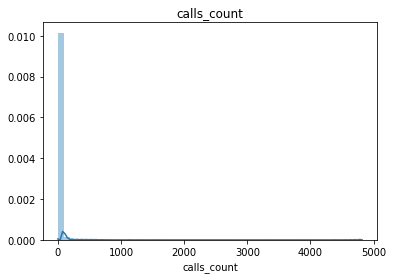

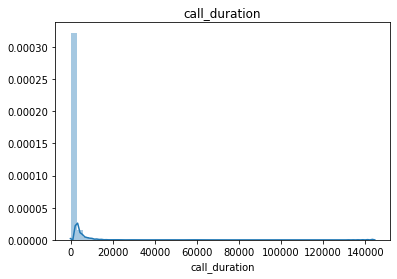

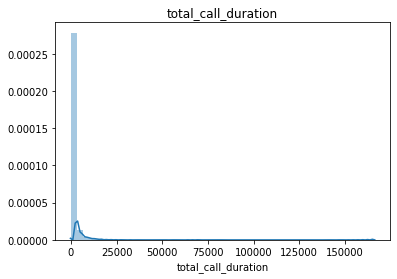

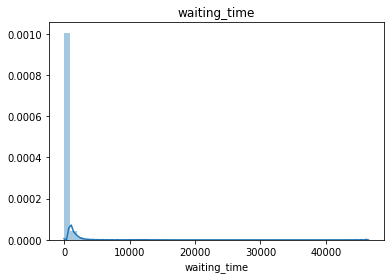

In [30]:
numerical_categories = ['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']

for category in numerical_categories:
    plt.figure();
    sns.distplot(merged_data_with_nan[category], kde=True, hist=True)
    plt.xlabel(category)
    plt.title(category)

    plt.show();

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
There are a significant outliers in the dataset, the distirbution is heavily right skewed. I suggest to drop the outliers above percentile 95%
</div>

In [31]:
for category in numerical_categories:
    print(category)
    print(np.percentile(merged_data_with_nan[category], [90, 95, 99])) 
    print(np.percentile(merged_data_nan_dropped[category], [90, 95, 99])) 

calls_count
[ 35.    62.   165.09]
[ 37.   65.  165.1]
call_duration
[ 2096.9   3730.45 10324.9 ]
[ 2407.   4161.5 10988.3]
total_call_duration
[ 2614.    4538.35 12969.99]
[ 2935.   5035.5 13654.1]
waiting_time
[ 615.   1164.45 3159.44]
[ 659.  1234.5 3495.4]


In [32]:
final_dataset_nan = merged_data_with_nan.query('calls_count<=62 and call_duration<=3730 and total_call_duration<=4538')
final_dataset_nan_skipped = merged_data_nan_dropped.query('calls_count<=65 and call_duration<=4161 and total_call_duration<=5035')

print(len(final_dataset_nan)/len(merged_data_with_nan))
print(len(final_dataset_nan_skipped)/len(merged_data_nan_dropped))

0.9232185224576618
0.925068087055024


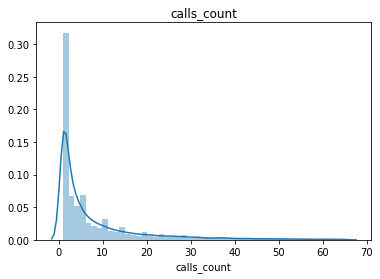

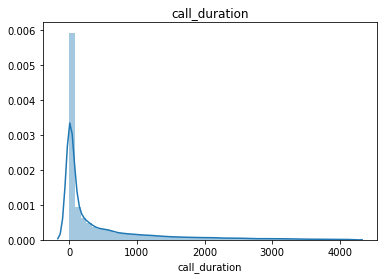

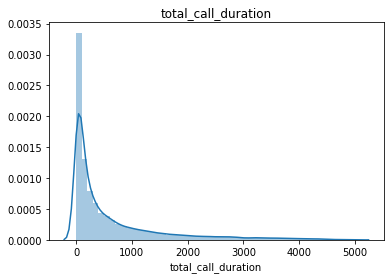

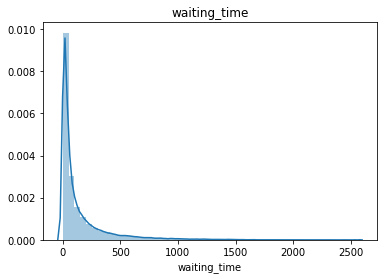

In [33]:
for category in numerical_categories:
    plt.figure();
    sns.distplot(final_dataset_nan_skipped[category], kde=True, hist=True)
    plt.title(category)
    plt.xlabel(category)
    plt.show();

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
By dropping outliers we lost less than 8% of original data. The distributions remain non normal
</div>

In [34]:
for category in numerical_categories:
    print('{} in first dataset(with NaNs): Mean value - {}, Median value - {}'.format(category,final_dataset_nan[category].mean(), final_dataset_nan[category].median()))
    print('{} in second dataset(without NaNs): Mean value - {}, Median value - {}'.format(category,final_dataset_nan_skipped[category].mean(), final_dataset_nan_skipped[category].median()))
    print()


calls_count in first dataset(with NaNs): Mean value - 7.819774912490584, Median value - 3.0
calls_count in second dataset(without NaNs): Mean value - 8.501354801729978, Median value - 4.0

call_duration in first dataset(with NaNs): Mean value - 385.9602330630511, Median value - 27.0
call_duration in second dataset(without NaNs): Mean value - 485.64613620968163, Median value - 89.0

total_call_duration in first dataset(with NaNs): Mean value - 522.5140015064912, Median value - 168.0
total_call_duration in second dataset(without NaNs): Mean value - 632.8160596112762, Median value - 236.0

waiting_time in first dataset(with NaNs): Mean value - 136.5537684434401, Median value - 47.0
waiting_time in second dataset(without NaNs): Mean value - 147.1699234015945, Median value - 51.0



<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
I dropped the outliers but the distributions are still non-normal. I will take it into account when calculating mean values (can be replaced by mode()) </div>

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
Lets do major calculations for each operator (1092 operators) </div>

In [35]:
operators = final_dataset_nan_skipped.groupby('operator_id').agg({'calls_count': 'mean', 'call_duration': 'mean', 'total_call_duration': 'mean', 'waiting_time': 'mean', 'is_missed_call': ['sum', 'count'], 'direction': ['sum', 'count']}).reset_index()
operators.columns = ['operator_id', 'calls_count_avg', 'call_duration_avg', 'total_call_duration_avg', 'waiting_time_avg', 'missed_calls_cnt', 'total_calls_cnt', 'direction_in', 'direction_total' ]
operators['direction_out'] = operators['direction_total']- operators['direction_in']
display(operators.head())
display(operators.shape)

,operator_id,calls_count_avg,call_duration_avg,total_call_duration_avg,waiting_time_avg,missed_calls_cnt,total_calls_cnt,direction_in,direction_total,direction_out
0,879896.0,5.508772,367.008772,452.026316,85.017544,47,114,21,114,93
1,879898.0,20.502674,462.010695,811.187166,349.176471,87,187,56,187,131
2,880020.0,2.250000,112.250000,126.250000,14.000000,6,20,7,20,13
3,880022.0,2.814286,216.385714,270.357143,53.971429,29,70,8,70,62
4,880026.0,12.263736,842.450549,964.428571,121.978022,87,182,18,182,164


(1092, 10)

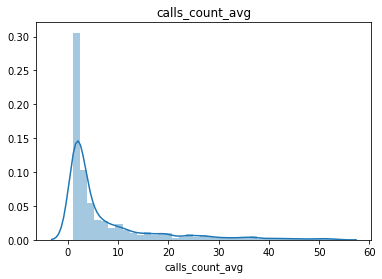

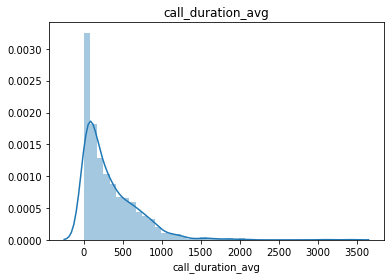

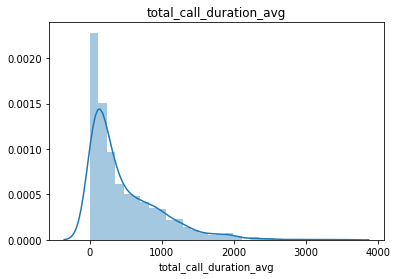

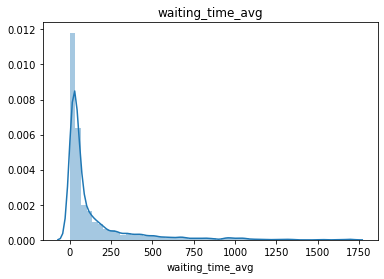

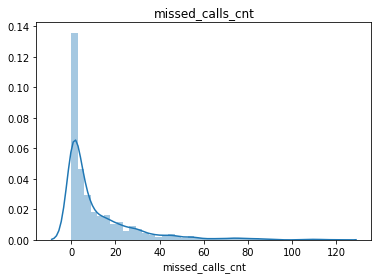

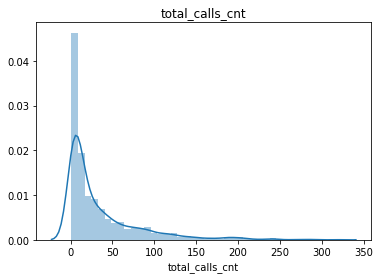

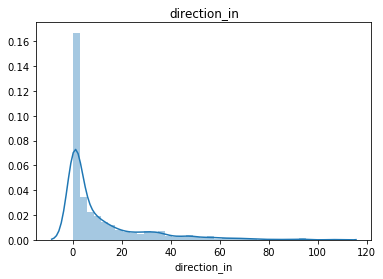

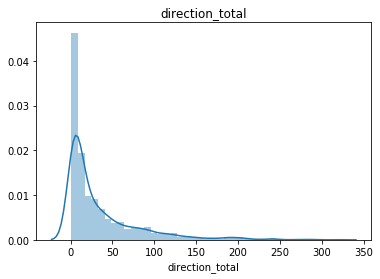

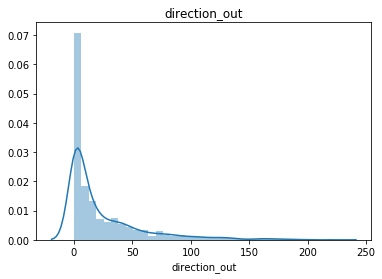

In [36]:
for category in operators.columns:
    if category != 'operator_id':
        plt.figure();
        sns.distplot(operators[category], kde=True, hist=True)
        plt.title(category)
        plt.xlabel(category)
        plt.show();

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
There are 210 users who are likely not supposed to make outgoing calls. Lets create two additional datasets based on this parameter: </div>

In [37]:
operators_without_out_calls = operators.query('direction_out == 0')
display(operators_without_out_calls.shape)
operators_with_in_out_calls = operators.query('direction_out > 0 and direction_in>0')
display(operators_with_in_out_calls.shape)
operators__out_calls_only = operators.query('direction_in == 0')
display(operators__out_calls_only.shape)

(210, 10)

(544, 10)

(338, 10)

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
It should be additionally mentioned that the waiting time category was calculated for both ingoing and outgoing calls. However, in order to analyze effectivity of operators it is reasonable to look at the dataslice of incoming calls only: </div>

In [38]:
incoming_calls = final_dataset_nan_skipped.query('direction == 1')
display(incoming_calls.shape[0]/final_dataset_nan_skipped.shape[0]*100)
operators_incalls = incoming_calls.groupby('operator_id').agg({'waiting_time': 'mean', 'is_missed_call':['sum', 'count']}).reset_index()
operators_incalls.columns = ['operator_id','waiting_time_avg', 'missed_calls', 'total_calls']

operators['waiting_time_avg'] = operators_incalls['waiting_time_avg']

32.09056328487312

In [39]:
display(operators_incalls.head())
display(operators_incalls.shape)

,operator_id,waiting_time_avg,missed_calls,total_calls
0,879896.0,27.333333,0,21
1,879898.0,29.875000,1,56
2,880020.0,7.714286,0,7
3,880022.0,14.000000,0,8
4,880026.0,7.944444,0,18


(754, 4)

In [40]:
print(operators.shape, operators_incalls.shape)

(1092, 10) (754, 4)


In [41]:
incoming_calls.is_missed_call.value_counts()

0    11705
1      612
Name: is_missed_call, dtype: int64

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
Only 32% of the original dataset is about incoming calls. So I added the average waiting time only for operators that make incoming calls (there are NaN values for waiting time in rows describing outgoing calls  </div>

In [42]:
for column in operators.columns:
    if column not in ['operator_id']:
        print('{}: Mean - {}, Median - {} \n'.format(column, operators[column].mean(),operators[column].median()))

calls_count_avg: Mean - 7.570227374137064, Median - 2.916277258566978 

call_duration_avg: Mean - 335.5670382085529, Median - 222.9689709347997 

total_call_duration_avg: Mean - 478.8356772220319, Median - 290.53785573653124 

waiting_time_avg: Mean - 51.65364077913168, Median - 30.775 

missed_calls_cnt: Mean - 12.147435897435898, Median - 5.0 

total_calls_cnt: Mean - 35.14835164835165, Median - 15.0 

direction_in: Mean - 11.27930402930403, Median - 3.0 

direction_total: Mean - 35.14835164835165, Median - 15.0 

direction_out: Mean - 23.86904761904762, Median - 9.0 



<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
All distributions are right skewed (based on both visalisations and mean/median calculations). I will use median values for further calculations (hypotheses) </div>

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
It should be mentioned that on the previous step the mean and median calculations (on missed calls) were made for both incoming and outgoing calls. Lets calculate the median and mean (on missed calls) only for incoming calls</div>

In [43]:
print('Mean:')
display(operators_incalls['missed_calls'].mean())
print('Median:')
display(operators_incalls['missed_calls'].median())

Mean:


0.8116710875331565

Median:


0.0

In [44]:
incoming_calls_2 = final_dataset_nan.query('direction == 1')
tariff_users = incoming_calls_2.groupby('tariff_plan').agg({'is_missed_call': ['sum', 'count', 'mean']})
tariff_users.columns = ['missed_calls_cnt', 'total_calls', 'avg_missed_calls']
tariff_users['missed_calls_cnt_%'] = tariff_users['missed_calls_cnt']/tariff_users['total_calls']*100
tariff_users
tariff_users.style.background_gradient(cmap='Blues')

,missed_calls_cnt,total_calls,avg_missed_calls,missed_calls_cnt_%
tariff_plan,,,,
A,1250,4395,0.284414,28.4414
B,2854,6636,0.430078,43.0078
C,3452,8191,0.421438,42.1438


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
There is difference in percentage of missed calls between users with A and C tariffs (incoming calls). Whether this difference is stastistically significant will be checked later </div>

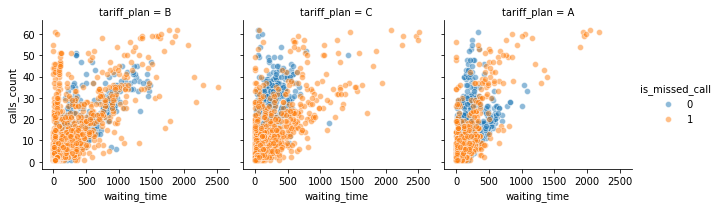

In [45]:
g = sns.FacetGrid(incoming_calls_2, col="tariff_plan", hue="is_missed_call")
g.map(sns.scatterplot, "waiting_time", "calls_count", alpha=.5)
g.add_legend()

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
On the scatter plot visualisation one may notice slight differences in  missed/non missed calls distributions between various tariff plans. In general, one may assume that the users on B plan demonstrate more patience to longer waiting time. However, in general, there ano not strong correlations between diffeent parameters </div>

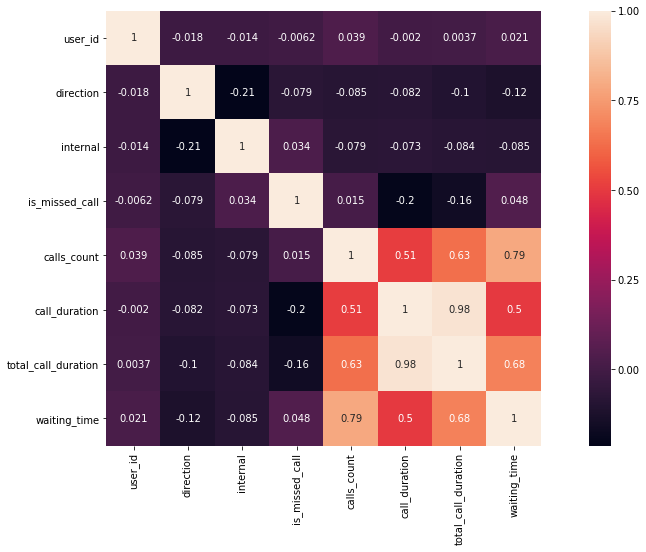

In [46]:
cm = merged_data_with_nan.corr()  
fig, ax = plt.subplots(figsize=(17, 8))
sns.heatmap(cm, annot = True, square=True)
plt.show()

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
There is no any uncommon correlations between various categories (only obvious ones) </div>

<div style="background-color:rgb(247, 194, 87); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
    <strong>General conclusions on EDA stage:</strong>
<ol>
    <li>The data in all categories within dataset is not distributed normally (the distributions are right skewed. In other words, there is a large number of ouliers and </li>
    <li> After dropping the most explicit outliers I got the following calculations results (for the dataslice without NaN values in operator_id):</li>
    <ol>
        <li>the average number of calls in one sequence of calls 9 calls (median - 4 calls) </li>
        <li>the average duration of one call is 486 sec (median - 89 sec) </li>
        <li>the average waiting time for the incoming calls is 147 sec (median 51 sec)</li>    
    </ol>
    <li>After grouping data by operators I got the following general calculations:
        <ol>
        <li>In average each operator processes 8 calls  (median - 3 calls)</li>
            <li>The average call duration per operator is 336 sec (median - 223 sec)</li>
            <li>The average waiting time for incoming calls per operator is 143 sec (median 45 sec)</li>
            <li>In average an operator misses 12 calls (incoming and outcoming) (median - 5 calls). If we speak only about incoming calls, in average operator misses 0.8 calls (median - 0). That means that most of missing calls are for outgoing calls (when operator cannot reach user for some external reason). In other words, the missed outgoing call cannot indicate ineffectivity of operator</li>
        </ol>
    </li>
    <li>In average, operator processes 11 incoming calls and 24 outcoming calls (median 3 and 9 respectively). </li>
    <li>No direct (linear) correlation was found between missing calls and any other category.</li>
    <li>There are differences in missed calls percentage for users on different tariff plans. The significance of these variations will be checked below</li>
    </ol>
    </div>

## Hypotheses <a class="anchor" id="chapter3"></a>

### <strong>1st hypothesis</strong>

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
<p> <strong>Null</strong>: There is no significant change in missed calls number when the average waiting time is more than <strong>value</strong> or when the average waiting time is less than <strong>value</strong> (the value will be defined after exploratory analysis).
<p> <strong>Alternative</strong>: The missed calls number changes when the average waiting time is more than <strong>value</strong> or when the average waiting time is less than <strong>value</strong>

Steps:
1. To find the mean (median) value of  waiting time (<strong>done in previous step: mean 51.65364077913168  </strong>). 
2. To use this data to split operators into 2 categories: with mean waiting time more than general mean value and with the mean waiting time less than general mean value.
3. To calculate the mean value of missed calls for each group.
4. To check statisical significance of variations. 
5. To draw conclusions concerning the correlation between waiting time and the number of missed calls.
    
    
Mann-Whitney test will be used to check hypotheses due to non normal distribution of the data
    </div>

In [47]:
def test(sample1, sample2):
    alpha = .05 #significance level
    results = st.mannwhitneyu(sample1,sample2)
    print('p-value: ', results.pvalue)
    if (results.pvalue < alpha):
        print("Null hypothesis rejected: the difference is statistically significant")
    else:
        print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

In [48]:
# the dataslice with incoming calls only
operators_incalls['missed_calls_cnt_%'] = operators_incalls['missed_calls']/operators_incalls['total_calls']*100
operators_incalls

,operator_id,waiting_time_avg,missed_calls,total_calls,missed_calls_cnt_%
0,879896.0,27.333333,0,21,0.000000
1,879898.0,29.875000,1,56,1.785714
2,880020.0,7.714286,0,7,0.000000
3,880022.0,14.000000,0,8,0.000000
4,880026.0,7.944444,0,18,0.000000
...,...,...,...,...,...
749,971102.0,286.000000,0,3,0.000000
750,971354.0,42.000000,0,2,0.000000
751,972412.0,25.000000,0,1,0.000000
752,972460.0,4.000000,0,1,0.000000


In [49]:
#splitting the data 
mean = 51.65364077913168
a_group = operators_incalls.query('waiting_time_avg < @mean')
b_group = operators_incalls.query('waiting_time_avg >= @mean')


In [50]:
display(a_group['missed_calls_cnt_%'].mean())
display(a_group['missed_calls'].mean())


3.8856705448195608

0.4044943820224719

In [51]:
display(b_group['missed_calls_cnt_%'].mean())
display(b_group['missed_calls'].mean())


6.103557129737909

1.8

In [52]:
test(a_group['missed_calls_cnt_%'], b_group['missed_calls_cnt_%'])

p-value:  1.0937085423144506e-09
Null hypothesis rejected: the difference is statistically significant


In [53]:
for i in operators_incalls.index:
    if operators_incalls.loc[i, 'waiting_time_avg']<mean:
        operators_incalls.loc[i, 'group'] = 'avg waiting time < 50 sec'
    else:
        operators_incalls.loc[i, 'group'] = 'avg waiting time > 50 sec'

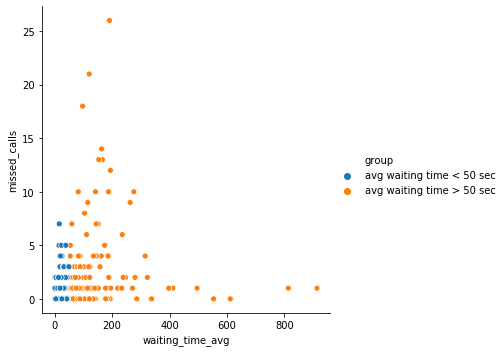

In [54]:
sns.relplot(x="waiting_time_avg", y="missed_calls", hue="group", data=operators_incalls)

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
According to the result of the test, there is a statistically significant difference in missed calls percentage in groups of operators (1) with average waiting time less than 50 sec and (2) with average waiting time more than 50 sec   </div>

### 2nd hypothesis

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
<strong>2rd hypothesis</strong>: checking the clients's patience depending on their tarif
<p>- Null: the mean value of missed incoming calls from A (cheap one) tariff does not differ from the mean value of missed incoming calls from C (expensive one) tariff plan.
<p>- Alternative: the mean value of missed incoming calls from A (cheap one) tariff differs from the mean value of missed incoming calls from C (expensive one) tariff plan.

Steps:

1. To split data into categories according to the tariff plan. 
2. To calculate mean value of missed calls for all groups.
3. To check statisical significance of variations.
4. To draw conclusions concerning the correlation between tariff plan and the number of missed calls.
    
</div>

In [55]:
tariff_users

,missed_calls_cnt,total_calls,avg_missed_calls,missed_calls_cnt_%
tariff_plan,,,,
A,1250,4395,0.284414,28.441411
B,2854,6636,0.430078,43.007836
C,3452,8191,0.421438,42.143816


In [56]:
a_group_2 = incoming_calls_2.query('tariff_plan == "A"')
b_group_2 = incoming_calls_2.query('tariff_plan == "C"')

In [57]:
test(a_group_2['is_missed_call'], b_group_2['is_missed_call'])

p-value:  3.902622461752701e-52
Null hypothesis rejected: the difference is statistically significant


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
According to the result of the test, there is a statistically significant difference in missed calls percentage in groups of users (1) on A tariff plan (cheap) (2) on B tariff plan (expensive)</div>

### 3th hypothesis

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
<strong>3th hypothesis</strong>:
<p>- Null: the mean value of number of missed calls from operators with many outgoing calls does not differ from the mean value of number of missed calls from operators with few outgoing  calls
<p>- Alternative: the mean value of missed incoming calls from A (cheap one) tariff differs from the mean value of missed incoming calls from C (expensive one) tariff plan.

Steps:

1. To make a data slice with operators who are supposed to make outgoing calls.
2. To calculate the mean value of number of outgoing calls.
3. To split operators in to groups (with the number of outgoing calls that less than the general mean value and with the number of outgoing calls that more than the general mean value).
3. To calculate the mean value of missed calls for each group. 
4. To check statisical significance of variations.
5. To draw conclusions concerning the correlation between the outgoing calls and the number of missed calls. </div>

In [58]:
operators_with_in_out_calls.head()

,operator_id,calls_count_avg,call_duration_avg,total_call_duration_avg,waiting_time_avg,missed_calls_cnt,total_calls_cnt,direction_in,direction_total,direction_out
0,879896.0,5.508772,367.008772,452.026316,85.017544,47,114,21,114,93
1,879898.0,20.502674,462.010695,811.187166,349.176471,87,187,56,187,131
2,880020.0,2.250000,112.250000,126.250000,14.000000,6,20,7,20,13
3,880022.0,2.814286,216.385714,270.357143,53.971429,29,70,8,70,62
4,880026.0,12.263736,842.450549,964.428571,121.978022,87,182,18,182,164


In [59]:
median_out_calls= operators_with_in_out_calls.direction_out.median()
median_out_calls

22.0

In [60]:
a_group_3 = operators_with_in_out_calls.query('direction_out<@median_out_calls')
b_group_3 = operators_with_in_out_calls.query('direction_out>@median_out_calls')

In [61]:
a_group_3['missed_calls_cnt'].mean()

4.270370370370371

In [62]:
b_group_3['missed_calls_cnt'].mean()

33.4812030075188

In [63]:
test(a_group_3['missed_calls_cnt'], b_group_3['missed_calls_cnt'])

p-value:  4.264414235635392e-86
Null hypothesis rejected: the difference is statistically significant


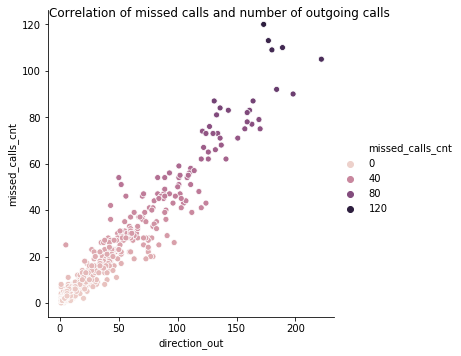

In [64]:
g = sns.relplot(x="direction_out", y="missed_calls_cnt", hue="missed_calls_cnt", data=operators_with_in_out_calls)
g.fig.suptitle('Correlation of missed calls and number of outgoing calls')
plt.show()

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
According to the result of the test, there is a statistically significant difference in missed calls number in groups of operators (1) with less than 15 outgoing calls in average (2)  with more than 15 outgoing calls in average</div>

### 4th hypothesis

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
<p>- Null: There is no significant change in average missed calls number when the average call duration is more than <strong>value</strong> or when the average call duration is less than <strong>value</strong> (the value will be defined after exploratory analysis).
<p>- Alternative: The average missing calls number changes when the average calls duration is more than <strong>value</strong> and when the average call duration is less than <strong>value</strong>
 
Steps:
    
1. To find the mean value of calls duration.
2. To use this data to split operators into 2 categories: with mean calls duration more than general mean value and with the mean calls duration less than general mean value.
3. To calculate the mean value of missed calls for each group.
4. To check statisical significance of variations.
5. To draw conclusions concerning the correlation between call count and the number of missed calls. 
    
    
<p> It is significant to mention that call duration and missed calls will be calculated for both incoming and outgoing calls    
</div>
    

In [65]:
mean = operators.call_duration_avg.mean()
median = operators.call_duration_avg.median()
display(mean, median)

335.5670382085529

222.9689709347997

In [66]:
a_group_4 = operators.query('call_duration_avg<@median')
b_group_4 = operators.query('call_duration_avg>=@median')

In [67]:
print('Mean value of missed calls (a group): {}'.format(a_group_4.missed_calls_cnt.mean()))
print('Mean value of missed calls (b group): {}'.format(b_group_4.missed_calls_cnt.mean()))

Mean value of missed calls (a group): 4.895604395604396
Mean value of missed calls (b group): 19.399267399267398


In [68]:
test(a_group_4['missed_calls_cnt'], b_group_4['missed_calls_cnt'])

p-value:  4.8735322138082165e-61
Null hypothesis rejected: the difference is statistically significant


In [69]:
for i in operators.index:
    if operators.loc[i, 'total_call_duration_avg']<median:
        operators.loc[i, 'group'] = 'Call duration is less 223 sec'
    else:
        operators.loc[i, 'group'] = 'Call duration is more 223 sec'

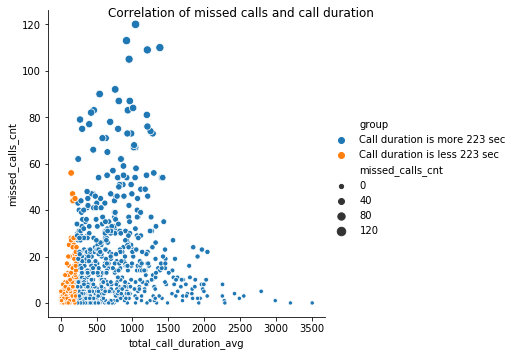

In [70]:
g = sns.relplot(x="total_call_duration_avg", y="missed_calls_cnt", hue='group', size="missed_calls_cnt", data=operators)
g.fig.suptitle('Correlation of missed calls and call duration')
plt.show()

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
According to the result of the test, there is a statistically significant difference in average missed calls number for operators with average call duration more than  290 sec and less than 290 sec</div>

<div style="background-color:rgb(247, 194, 87); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
    <strong>General conclusions on Hypothesis testing stage:</strong>
    <ol>
        <li>The call with longer waiting time is more likely to be missed </li>
        <li>The average percentage of missed calls is higher for users on expensive (C) tariff plan rather than on cheap (A) tariff plan</li>
        <li>The average number of missed calls is more for operators who process more outgoing calls</li>
        <li>The average number of missed calls is more for operators with greater call duration.</li>
    </ol>
</div>

## Applying machine learning  <a class="anchor" id="chapter4"></a>

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">We can try to apply clustering in order to split operators intro groups based on various parameters. Perhaps, we will define the typical portrait of an effective and ineffective operator.</div>

<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">I will apply clustering algorithm on operator oriented dataset (containing only the incoming calls).</div>

In [71]:
X = operators.drop(['operator_id', 'call_duration_avg', 'total_call_duration_avg', 'group'], axis=1)
X_upd = X.query('direction_out == 0')
X_upd = X_upd.dropna()
sc = StandardScaler()
X_sc = sc.fit_transform(X_upd)

In [72]:
linked = linkage(X_sc, method = 'ward')

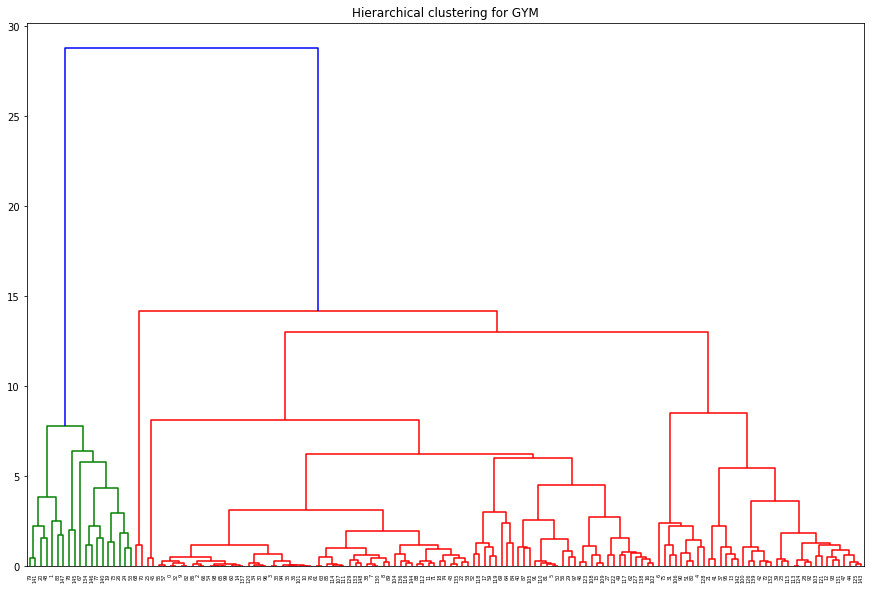

In [73]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for GYM')
plt.show() 

In [74]:
km = KMeans(n_clusters = 2) 
labels = km.fit_predict(X_sc)
final_with_clasters = operators.query('direction_out == 0').dropna()
final_with_clasters['cluster'] = labels

In [75]:
cluster_mean_features = final_with_clasters.groupby('cluster').mean()
cluster_mean_features

,operator_id,calls_count_avg,call_duration_avg,total_call_duration_avg,waiting_time_avg,missed_calls_cnt,total_calls_cnt,direction_in,direction_total,direction_out
cluster,,,,,,,,,,
0,913592.080000,1.526549,129.654861,162.304265,63.807707,0.352,7.496000,7.496000,7.496000,0.0
1,912246.166667,2.931291,327.517394,377.872768,71.949258,1.750,44.041667,44.041667,44.041667,0.0


<div style="background-color:rgb(202, 225, 246); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">Based on the results of clustering algorithm, one may conclude that there are two types operators:

<p>1. Operators with shorter average waiting time (for incoming calls) with shorter average call duration with smaller average total number of calls and with smaller average number of missed calls.
<p>2. Operators with longer average waiting time (for incoming calls) with longer average call duration with lower average total number of calls and with greater average number of missed calls.
    
<p>Please look at the diagonal in the pairplot below for better visualisation

</div>

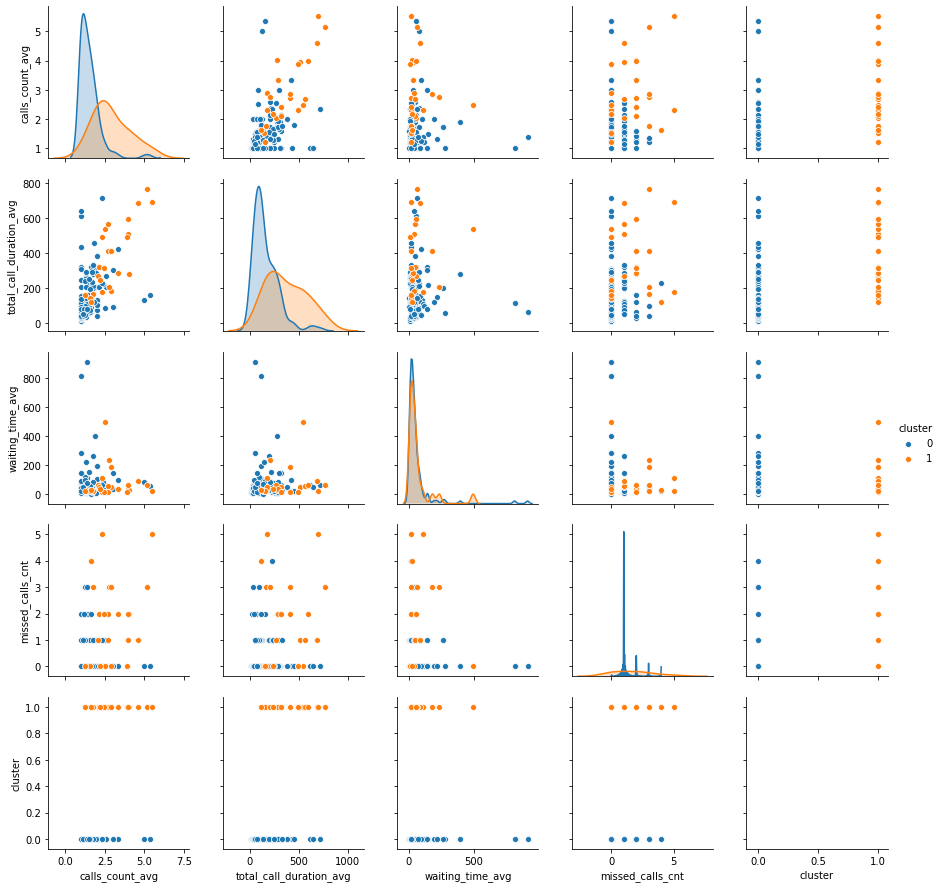

In [76]:
sns.pairplot(final_with_clasters[['calls_count_avg', 'total_call_duration_avg', 'waiting_time_avg', 'missed_calls_cnt', 'cluster']], hue='cluster')




<div style="background-color:rgb(247, 194, 87); text-align:left; border-style: dotted solid; vertical-align: middle; padding:20px 10px;">
<p>In attempt to connect these results with the effectivity issue, I would suggest that longer average waiting time for incoming call indeed may lead to greater average number of missed incoming calls that in turn indicates lower effectivity of operator.
    
<p> On the other hand, another parameters such as longer average call duration (that is not connected with operator effectivity) might lead to the lower average total number of calls and also to the greater average number of missed calls (actually it was proved by the 4th hypothesis test).
    
</div>

## General conclusions and recommendations  <a class="anchor" id="chapter5"></a>

The goal of the research was to identify ineffective operators in the virtual telephony service CallMeMaybe based on three major parameters:

- the number of missed calls,
- waiting time for incoming calls,
- number of outgoing calls (if it is relevant for a particular operator).

Accoring to the analysis, operator misses in average 12 calls (both incoming and outgoing), the median value for missed calls per operator is 5 calls. However, it is significant to mention that if we speak only about incoming calls, in average operator misses 0.8 calls (median - 0). That means that most of missing calls are for outgoing calls (when operator cannot reach user for some external reason). In other words, the missed outgoing calls cannot indicate ineffectivity of operator (in case it is not any technical issue that we are not able to detect looking at the current dataset). 

Based on the results of hypotheses tests and clustering algorithm I may coclude that the average number of missed called correlates with the waiting time per operator (for incoming calls), average call duration per operator (for both incoming and outgoing calls), average number of calls in sequence. 

The issue is that call duration is user-oriented parameter and it cannot indicate operator's effectivity. Nevetheless, the call duration (as proved in Hypothesis 4 test) does influence the number of missed calls (that is supposedly the major indicator of operator's effectivity).

I may assume that the following sequence of events may result in high number of missed calls for a particular operator:

<strong>longer call duration --> longer waiting time --> greater number of missed calls</strong>

Additionally, I have noticed that (3rd hypothesis test) the average number of missed calls is greater for operators who process more outgoing calls. It seems logical because taking into account the general effectivity of operators for incoming calls (average missed calls is less than 1) one may assume that missed calls number in most cases is correlated with user's activity factor.

Moreover, (2nd hypothesis test) one may assume that the number of missed calls can correlate with various expectations and patience level of user on different tariff plans. I may suggest that users on more expensive tariff plan expect less waiting time that is why the number of missed calls can be higher for incoming calls for them,other things being equal.

To conclude, the idea of effectivity identification of operator can be paraphrased as the idea of <strong>identification of problematic situations</strong> (such as extremely long call duration, long waiting time for C tariff users and so on) with the aim of developing better algorithms to avoid such problematic situations.

In light of the above I would suggest:
- to analyse larger dataset of incoming calls for higher accuracy of results.
- to analyse deeper users behaviour (for instance, to try find any correlations for new and old users based on the different between the registration date and call date) and to define problematic situations based on combination of several parameters (call duration+outgoing direction, call duration + C tariff user, waiting time and old user and so on).

Based on the conclusions from the current research I would suggest to develop better algorithms to redirect the calls to less "busy"(with smaller waiting time) operator in order to avoid <strong>problematic situations</strong> discussed above. 

